### Pangeo: Near Surface Temperature Anomaly Animation of Two Scenarios 

**Packages:**

- matplotlib
- numpy
- pandas 
    - *tool for reading data*, *data analysis and manipulation*
- xarray 
    - *for handling of multidimensional arrays*
- zarr 
    - *format for the storage of chunked, compressed, multidimensional arrays*
- fsspec 
    - *for accessing data from Google Cloud Storage*
-   gcsfs
    - *for accessing to Google Storage*
- xesmf 
    - *for regridding geospatial data*
- cartopy 
    - *for processing geospatial data and creating maps*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import xesmf as xe

In [2]:
#reading CSV file with pandas
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
#if you want to change the variable to precipitation change this to 'pr'
variable = 'tas'

#the two scenarios
scenario_1 = 'ssp119'
scenario_2 = 'ssp585'

In [4]:
#filtering data by variable (monthly near surface temperature)
df_tas = df.query(f"table_id == 'Amon' & variable_id == '{variable}'")
df_tas

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
24,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
45,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
82,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
126,HighResMIP,MOHC,HadGEM3-GC31-LM,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170906
187,HighResMIP,ECMWF,ECMWF-IFS-HR,control-1950,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/HighResMIP/ECMWF/ECMWF-IFS-HR...,NaN,20170915
...,...,...,...,...,...,...,...,...,...,...,...
523651,ScenarioMIP,MIROC,MIROC6,ssp245,r29i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp2...,NaN,20210917
523701,CMIP,MOHC,HadGEM3-GC31-LL,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piC...,NaN,20211103
523712,CMIP,CMCC,CMCC-CM2-SR5,historical,r3i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211108
523721,CMIP,CMCC,CMCC-CM2-SR5,historical,r2i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211109


In [5]:
#Let's choose only the models that are found for the ssp119
df_s1=df_tas[(df_tas["experiment_id"] == scenario_1) & (df_tas["member_id"]=='r1i1p1f1')]

models = df_s1.source_id.unique()
model_count = len(models)
models

array(['GFDL-ESM4', 'MRI-ESM2-0', 'IPSL-CM6A-LR', 'CanESM5',
       'CAMS-CSM1-0', 'MIROC6', 'EC-Earth3-Veg', 'FGOALS-g3',
       'EC-Earth3-Veg-LR'], dtype=object)

In [6]:
#historical + SSP585
df_s2 =df_tas[(df_tas["experiment_id"].isin(['historical', scenario_2])) & (df_tas["member_id"]=='r1i1p1f1') & (df_tas["source_id"].isin(models))]
df_s2

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
29231,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
44593,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
55765,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222
94452,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
100305,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
212635,ScenarioMIP,MIROC,MIROC6,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp5...,NaN,20190627
217228,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,NaN,20190708
217462,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
244695,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [7]:
#historical + SSP119
df_s1 =df_tas[(df_tas["experiment_id"].isin(['historical', scenario_1])) & (df_tas["member_id"]=='r1i1p1f1') & (df_tas["source_id"].isin(models))]
df_s1

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
11914,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp119,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
29231,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
44593,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/...,NaN,20181212
55673,ScenarioMIP,MRI,MRI-ESM2-0,ssp119,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...,NaN,20190222
55765,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222
73769,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp119,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190410
100305,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
130759,ScenarioMIP,CCCma,CanESM5,ssp119,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429
217462,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
217781,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp119,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,NaN,20190708


In [8]:
#Different models have different grids which is why the data needs first to be interpolated to same grid to be able to calculate mean values of multiple models.

#creating 1x1 grid
grid_1x1 = xr.Dataset()
grid_1x1['lon'] = xr.DataArray(data=0.5 + np.arange(360), dims=('lon'))
grid_1x1['lat'] = xr.DataArray(data= 0.5 -90 + np.arange(180), dims=('lat'))
grid_1x1['lon_b'] = xr.DataArray(data=np.arange(361), dims=('lon, nbnd'))
grid_1x1['lat_b'] = xr.DataArray(data=-90 + np.arange(181), dims=('lat, nbnd'))
grid_1x1

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, lon, nbnd: 361, lat, nbnd: 181)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: lon, nbnd, lat, nbnd
Data variables:
    lon_b    (lon, nbnd) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    lat_b    (lat, nbnd) int64 -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90

In [9]:
models_s1 = df_s1.source_id
models_s2 = df_s2.source_id
model_count  = len(models_s1)
model_count

18

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
#function that opens the datasets and returns a list of datasets regridded to 1x1 grid along side with the name and units of variable
def open_and_regrid(df):
    tas_regridded = []

    for i in range(model_count):
        zstore = df.zstore.values[i]
        print(zstore)

        #mapping-style interface to the store
        mapper = fsspec.get_mapper(zstore)

        #opening dataset with xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True)

        #regridding data with conservative method to 1x1 grid
        regrid_to_1x1 = xe.Regridder(ds, grid_1x1, 'conservative', periodic=True)
        dr_out = regrid_to_1x1(ds[variable])

        #saving regridded tas-data as annual means 
        tas_regridded.append(dr_out.groupby('time.year').mean(dim='time'))

    name = ds[variable].long_name
    units = ds[variable].units
        
    return tas_regridded, name, units

In [12]:
#historical + SSP119 data
tas_regridded_s1, name, units = open_and_regrid(df_s1)

#concats the moldels and then calculates mean temperature over all of the models
tas_mean_s1 = xr.concat(tas_regridded_s1, pd.Index(models_s1, name="source_id"), coords='minimal').mean('source_id')
tas_mean_s1

gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp119/r1i1p1f1/Amon/tas/gr1/v20180701/
gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/
gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/
gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp119/r1i1p1f1/Amon/tas/gn/v20190222/
gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/r1i1p1f1/Amon/tas/gn/v20190222/
gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp119/r1i1p1f1/Amon/tas/gr/v20190410/
gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/v20190429/
gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp119/r1i1p1f1/Amon/tas/gn/v20190429/
gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f1/Amon/tas/gn/v20190708/
gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp119/r1i1p1f1/Amon/tas/gn/v20190708/
gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/tas/gr1/v20190726/
gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp119/r1i1p1f1/Amon/tas/gn/v20190807/
gs://c

<xarray.DataArray (year: 251, lat: 180, lon: 360)>
dask.array<mean_agg-aggregate, shape=(251, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
    height   float64 2.0

In [13]:
#historical + SSP858 data
tas_regridded_s2, name, units = open_and_regrid(df_s2)

#concats the moldels and then calculates mean temperature over all of the models
tas_mean_s2 = xr.concat(tas_regridded_s2, pd.Index(models_s2, name="source_id"), coords='minimal').mean('source_id')
tas_mean_s2

gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/
gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/
gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/
gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/r1i1p1f1/Amon/tas/gn/v20190222/
gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Amon/tas/gn/v20190429/
gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/v20190429/
gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp585/r1i1p1f1/Amon/tas/gn/v20190627/
gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585/r1i1p1f1/Amon/tas/gn/v20190708/
gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f1/Amon/tas/gn/v20190708/
gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/tas/gr1/v20190726/
gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gn/v20190818/
gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1i1p1f1/Amon/tas/gn/v20190818/
gs://cmip6/CMI

<xarray.DataArray (year: 451, lat: 180, lon: 360)>
dask.array<mean_agg-aggregate, shape=(451, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2296 2297 2298 2299 2300
    height   float64 2.0

In [14]:
from dask.diagnostics import ProgressBar

#load is one of dask commands that executes the computations and loads data into memory          
#this might take a while but it does make the plotting and animating part significantly faster
with ProgressBar():
    tas_mean_1 = tas_mean_s1.load()

[########################################] | 100% Completed | 348.36 s


In [15]:
with ProgressBar():
    tas_mean_2 = tas_mean_s2.load()

[########################################] | 100% Completed | 347.75 s


In [16]:
#Mean temperature of 1850-1900 (from all the models) (historical values are the same in both)
tas_rel = tas_mean_2.sel(year = slice('1850','1900')).mean('year')

In [17]:
#calculate global mean

def GlobalMean(data):
    #creating weights to weight data according to surface area
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    #calculating weighted global means
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("lon", "lat"))
    return weighted_mean

In [18]:
#calculating global mean of tas anomalies
ta_timeseries_1 = GlobalMean(tas_mean_1-tas_rel)
ta_timeseries_2 = GlobalMean(tas_mean_2-tas_rel)

In [19]:
ta_timeseries_1 = ta_timeseries_1.sel(year = slice(1850,2100)).load()
ta_timeseries_2 = ta_timeseries_2.sel(year = slice(1850,2100)).load()

In [20]:
#packages used in plotting
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cmocean #this is just for nice looking colorpalette, (you can also just use one of the colormaps from matplotlib)

In [21]:
#if you want to change the variable you can also change the colormap to something that fits better
colormap = cmocean.cm.balance #(or for example cmap = "coolwarm", "bwr" or "RdBu_r")

#temperature change is same in kelvins and celcisus degrees
if units=='K':
    units = '$ ^\circ$C'

#now the limits for map colors are defined from the max value, but you can also change it into a value you want
max = 0.4*(tas_mean_1-tas_rel).max()

In [22]:
tas_mean_2.lon

<xarray.DataArray 'lon' (lon: 360)>
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    height   float64 2.0

1850
1850
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047


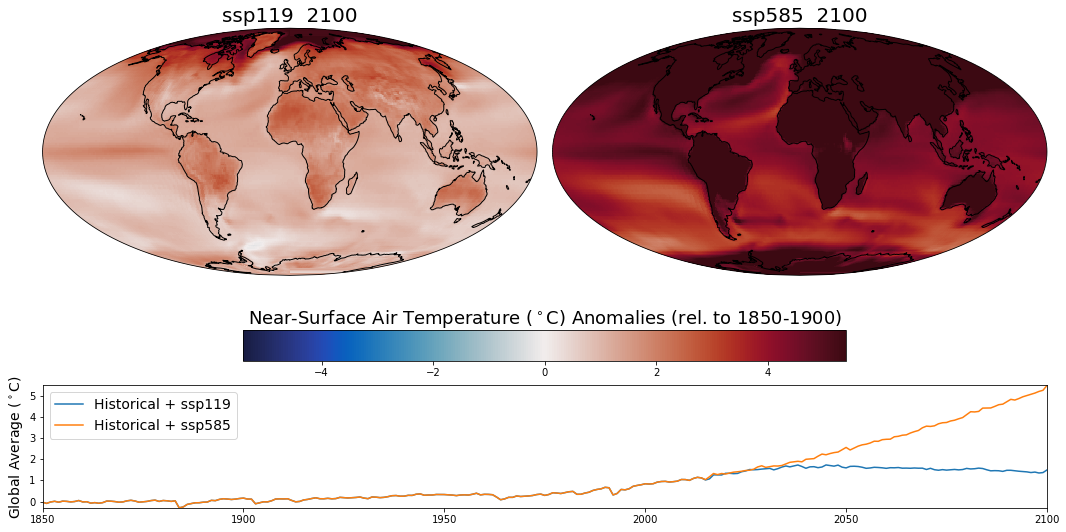

In [23]:
#defining the figure and placements of subplots 
fig = plt.figure(figsize=(18, 9), facecolor='white')
#this grid is used to organize subplots 
grid = plt.GridSpec(4, 6, wspace=0.1, hspace=0)
ax1 = fig.add_subplot(grid[0:3,:3], projection=ccrs.Mollweide()) #map 1
ax2 = fig.add_subplot(grid[0:3,3:], projection=ccrs.Mollweide()) #map 2
ax3 = fig.add_subplot(grid[3,0:]) #lineplot

#Subplot 1
#creating global map and coastlines to first map
ax1.set_global()
ax1.coastlines()
#defining data for the plot
data1 = tas_mean_1-tas_rel
lons= grid_1x1.lon
lats = grid_1x1.lat
#creating the mesh and title that will be updated each frame during the animation
mesh1 = ax1.pcolormesh(lons, lats, data1[0], animated = True, transform = ccrs.PlateCarree(), cmap= colormap,  vmin=-max, vmax=max)
title1 = ax1.set_title('',transform=ax1.transAxes)


#Subplot 2
#creating global map and coastlines to second map
ax2.set_global()
ax2.coastlines()
#defining data
data2 = tas_mean_2-tas_rel
#creating the mesh title that will be updated each frame during the animation
mesh2 = ax2.pcolormesh(lons, lats, data2[0], animated = True, transform = ccrs.PlateCarree(), cmap = colormap,  vmin=-max, vmax=max)
title1 = ax2.set_title('',transform=ax2.transAxes)

#placing horizontal colorbar under the maps
cbar = plt.colorbar(mesh1, ax = [ax1,ax2], orientation='horizontal', shrink=0.6, location='bottom')
cbar.ax.set_title(f'{name} ({units}) Anomalies (rel. to 1850-1900)',fontsize=18)


#Subplot 3
#Defining two line with labels to the third plot
line1, = ax3.plot([],[], label=f'Historical + {scenario_1}')
line2, = ax3.plot([],[], label=f'Historical + {scenario_2}')
#setting labels and limits for axes
ax3.set_ylabel(f'Global Average ({units})', size=14)
ax3.set_xlim(1850,2100)
ax3.set_ylim(ta_timeseries_2.min(),ta_timeseries_2.max())
#creating legend into the left corner
ax3.legend(loc='upper left',fontsize=14)
#lists of data that will be updated during the animation
xdata, y1data, y2data = [], [], []


#determining size of the titles (so that it's easy to adjust from here)
text_size = 20

def update(t):
    year = 1850+t
    print(year)
    #updating mesh1 and mesh2
    mesh1.set_array(data1[t].values.ravel())
    mesh2.set_array(data2[t].values.ravel())
    #adding new point in time to data lists of subplot 3
    xdata.append(ta_timeseries_1.year[t])
    y1data.append(ta_timeseries_1[t])
    y2data.append(ta_timeseries_2[t])
    #updating the data of line1 and line2
    line1.set_data(xdata, y1data)
    line2.set_data(xdata, y2data)
    #updating the titles above the two maps
    if year < 2015:
        ax1.set_title(f'Historical {year}', size=text_size)
        ax2.set_title(f'Historical {year}', size=text_size)
    else:
        ax1.set_title(f'{scenario_1}  {year}',size=text_size)
        ax2.set_title(f'{scenario_2}  {year}',size=text_size)
    return (mesh1,mesh2,line1,line2,)

#number of years we want to animate
n = 251
ts = [i for i in range(n)]
#Adding few more frames to show the end situataion
ts = ts + 15*[n-1]

#animating 251 (+15) frames with 200 milliseconds between each frame
ani = FuncAnimation(fig, update, frames=ts, init_func=None, blit=True, interval=200, repeat=False)

#saving the animation as mp4-video
ani.save(f"{variable}-anom-two-scen.mp4")